# Optical cavity alignment
A notebook for...
* Plotting transverse modes satisfying the paraxial wave equation
* Calculating overlap of input Gaussian beam with higher-order modes for misaligned cavity
* Plotting higher order mode spectrum

In [356]:
## general imports
import numpy as np
from numpy import *
fact = np.math.factorial

import scipy as sp
from scipy.integrate import quad, dblquad
from scipy.special import eval_hermite as Hermite
from scipy.special import eval_genlaguerre as Laguerre
from scipy.interpolate import RegularGridInterpolator

from matplotlib import colors
import matplotlib.pyplot as plt
from time import time,sleep
from random import random as rand
import csv

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from simfuncs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('.','images')
print("images saved in", imagedir)

# define some length units
mm = 10**-3
um = 10**-6
nm = 10**-9

C:\Users\prest\AppData\Local\Temp\ipykernel_11788\1589182025.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, Image


images saved in .\images


In [225]:
def HGmn(w0,lmbda,m,n):
    """
    return a lambda function Amn(x,y,z) for the amplitude of the 
    (m,n)th Hermite-Gaussian beam with fundamental waist w0
    at location z.
    """
    
    k = 2*pi/lmbda # wavenumber
    zR = pi*w0**2/lmbda # Rayleigh range
    w = lambda z: w0*sqrt(1+(z/zR)**2) # width
    R = lambda z: z*(1+(zR/z)**2) # radius of curvature
    eta = lambda z: arctan(z/zR) # Guoy phase
    
    Amn = lambda x,y,z: (sqrt(2/(pi*2**(m+n)*fact(m)*fact(n)))
                        *(Hermite(m,sqrt(2)*x/w(z))*Hermite(n,sqrt(2)*y/w(z)))
                        *exp(-(x**2+y**2)/w(z)**2)
                        *exp(1j*k*(x**2+y**2)/(2*R(z)))
                        *exp(-1j*(1+m+n)*eta(z))/w(z))
    return Amn


def dblquad_complex(func, ax, bx, ay, by, **kwargs):
    """
    Compute a double integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    
    returns a 3-tuple (result, real error, imaginary part error)
    """
    def real_func(x,y):
        return real(func(x,y))
    def imag_func(x,y):
        return imag(func(x,y))
    real_integral = dblquad(real_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    imag_integral = dblquad(imag_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

## Spatially multi-mode fields

In [2]:
def hermite_gaussian(m,n,w0):
    """
    return a function Amn(x,y) for the amplitude of the 
    (m,n)th Hermite-Gaussian beam, taking args x,y and 
    assuming the beam is in focus (z=0) with waist w0.
    """
    
    
    
    return lambda x,y: sqrt(2/(pi*2**(m+n)*fact(m)*fact(n)))*(
                        Hermite(n,sqrt(2)*x/w0)*Hermite(m,sqrt(2)*y/w0)
                        )*exp(-(x**2+y**2)/w0**2)/w0

def LG(p,l,w0):
    """
    return a function Apl(rho,phi) for the amplitude of the 
    (p,l)th Laguerre-Gaussian beam, taking args rho,phi and 
    assuming the beam is in focus (z=0) with waist w0.
    """
    eta2pl = 0 #(2*p+abs(l)+1)*eta(z) # guoy phase. not relevant for my purposes 
    def lg_pl(x,y): 
        rho = sqrt(x**2 + y**2)
        phi = arctan2(y,x)
        field = (sqrt(2*fact(p)/(pi*fact(p+abs(l))))*(sqrt(2)*rho/w0)**abs(l)
                 *Laguerre(p,abs(l),2*(rho/w0)**2)*exp(-1j*eta2pl)
                 *exp(-(rho/w0)**2)*exp(-1j*l*phi)/w0)
        return field
    return lg_pl

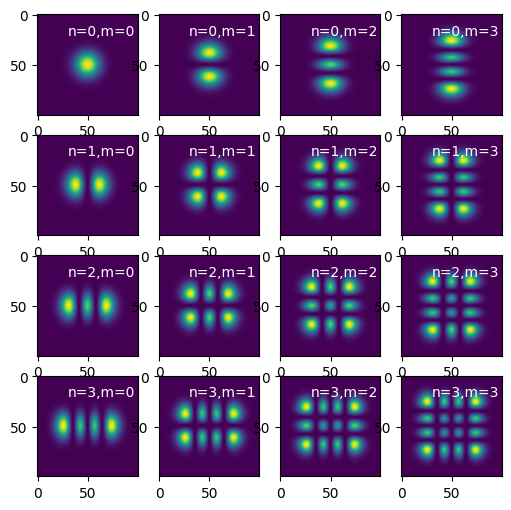

In [3]:
w0 = 1
hw = 3*w0
pts = 100
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 4
fig,axes = plt.subplots(nrange,nrange,figsize=(6,6))
for n in range(nrange):
    for m in range(nrange):
        mode = hermite_gaussian(m,n,w0)
        axes[n][m].imshow(mode(xx,yy)**2)
        axes[n][m].text(30,20,f'n={n},m={m}',color='white')

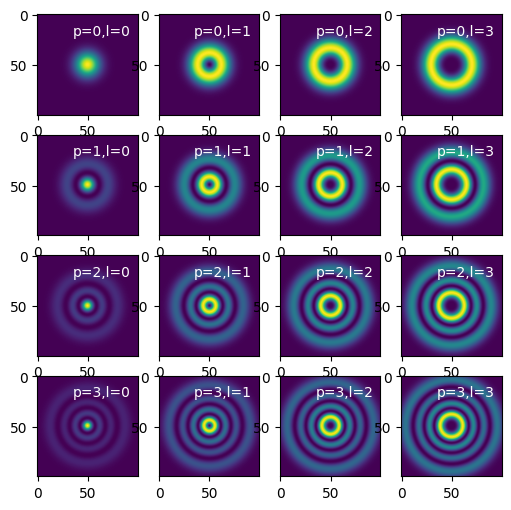

In [4]:
## sample of LG beams
w0 = 1
hw = 3*w0
pts = 100
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 4
fig,axes = plt.subplots(nrange,nrange,figsize=(6,6))
for l in range(nrange):
    for p in range(nrange):
        mode = LG(p,l,w0)
        axes[p][l].imshow(abs(mode(xx,yy))**2)
        axes[p][l].text(35,20,f'p={p},l={l}',color='white')

## Misaligned optical cavities
For a linear optical cavity made of two spherical mirrors, the cavity mode axis is the line which goes through the center of curvature of each mirror. A perturbation, i.e. a translation or tilt, of one of the mirrors will lead to a tilt in the mode axis. A fundamental Gaussian input beam aligned wrt to the unperturbed cavity mode axis and with the waist size and location matched to that of the unperturbed cavity, will then couple to higher-order modes.

In [ ]:
"""
to-do
* put expressions for cavity mode tilt as a function of mirror
tilt and translation. see my handwritten notes
* make contour plot of overlap between perturbed cavity A00 and
tilted A00
* plot cavity spectrum using coefficients giving overlap of A00
and tilted Amn modes
* primatively model cavity birefringence by introducing mode splitting nu_pol \propto sin(phi) with the phi the rotation of the mirror about the cavity axis 
"""

## Some sanity checks

In [221]:
# setup
w0 = 0.01*mm
lmbda = 7.8*10**-4*mm
zR = pi*w0**2/lmbda
z = 10**-9*mm

# limits for the numerical integration. x >> w0 is basically infinity
xmax = ymax = 20*w0
xmin = ymin = -xmax

# overlap of any mode with itself should be 1
A00 = HGmn(w0,lmbda,0,0)

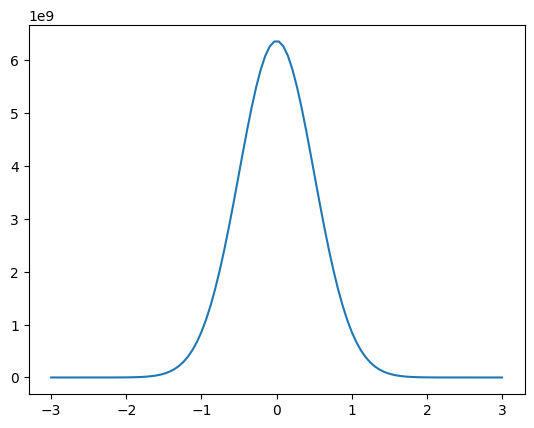

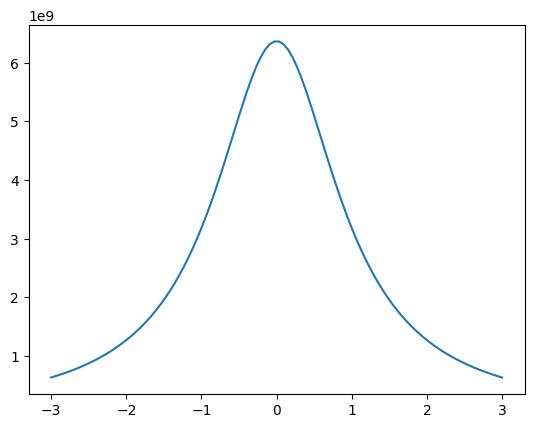

In [206]:
xpts = linspace(-3*w0,3*w0,100)
plt.plot(xpts/w0,abs(A00(xpts,0,10**-9))**2)
plt.show()

zpts = linspace(-3*zR,3*zR,100)
plt.plot(zpts/zR,abs(A00(0,0,zpts))**2)
plt.show()

Text(0.5, 0, 'dx')

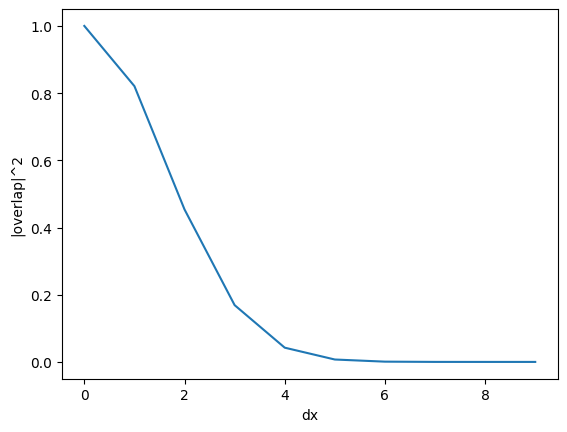

In [207]:
steps = 10
overlap_sqrd = np.zeros(steps)
dx = 4*w0/(steps-1) # displace the mode by 4*wo over the whole run
for i in range(steps):
    integrand = lambda x,y: conjugate(A00(x,y,z))*A00(x-dx*i,y,z)
    overlap_sqrd[i] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
plt.plot(overlap_sqrd)
plt.ylabel("|overlap|^2")
plt.xlabel("dx")

In [209]:
zR/w0

40.27682889217683

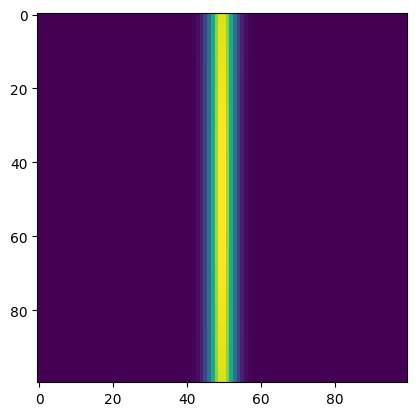

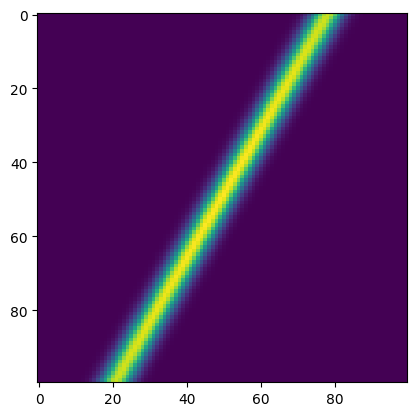

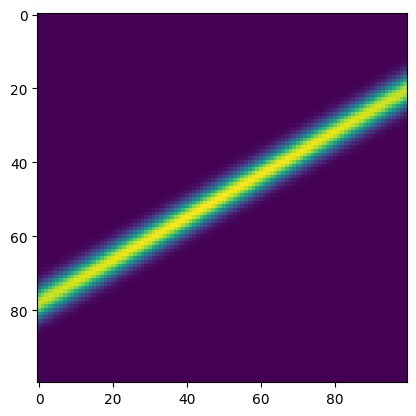

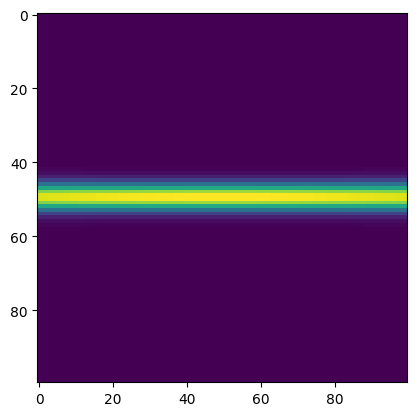

In [222]:
## plot modes rotated about y, viewed in the x-z plane
hw = 10*w0
pts = 100
xarr, midpt, xx, zz = get_meshgrid(hw,pts)

theta_steps = [0,pi/6,2*pi/6,pi/2]

for theta in theta_steps:
    plt.imshow(abs(A00(xx*cos(theta)+zz*sin(theta),0,-xx*sin(theta)+zz*cos(theta)))**2)
    plt.show()

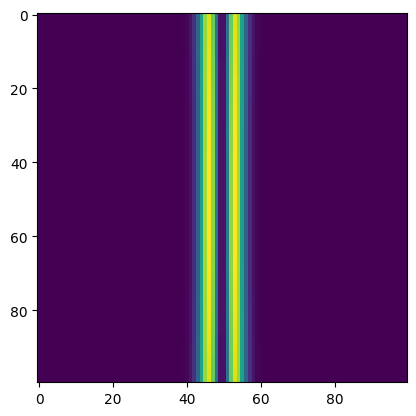

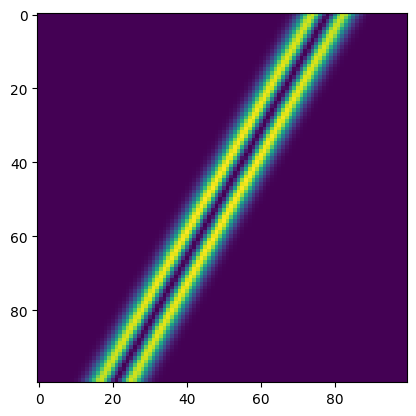

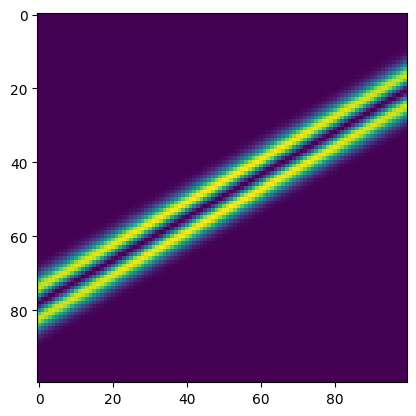

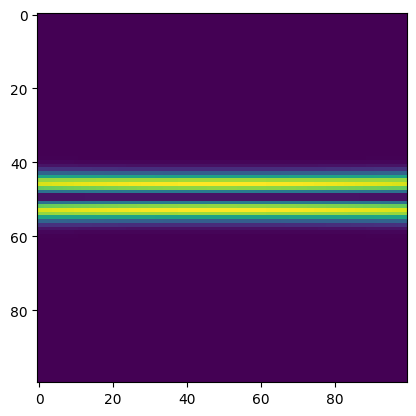

In [226]:
## plot modes rotated about y, viewed in the x-z plane
hw = 10*w0
pts = 100
xarr, midpt, xx, zz = get_meshgrid(hw,pts)

theta_steps = [0,pi/6,2*pi/6,pi/2]

m=1
Am0 = HGmn(w0,lmbda,m,0)

for theta in theta_steps:
    plt.imshow(abs(Am0(xx*cos(theta)+zz*sin(theta),0,-xx*sin(theta)+zz*cos(theta)))**2)
    plt.show()

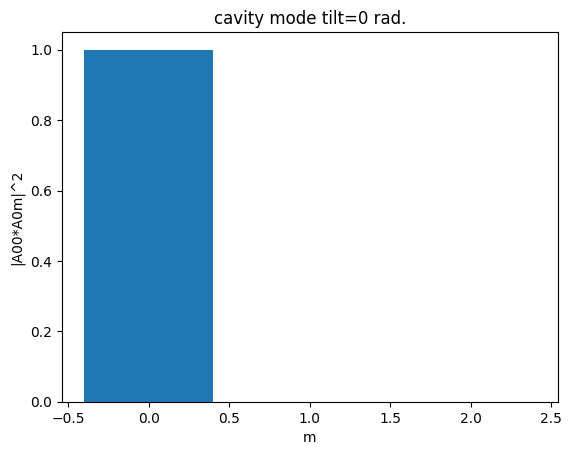

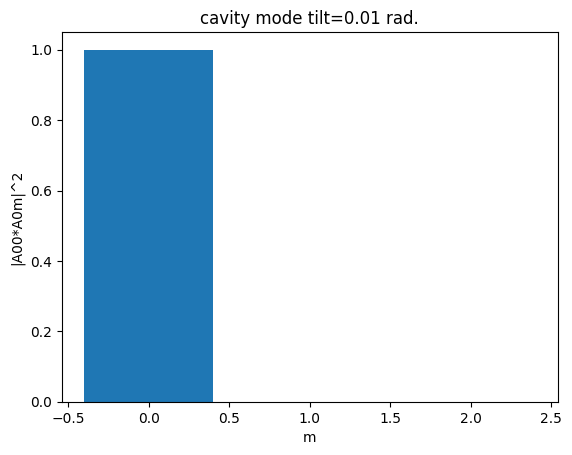

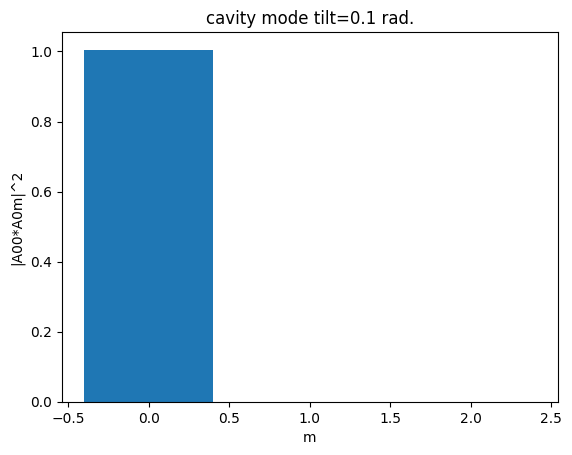

In [227]:
# find the overlap between the fundamental mode and the first couple of modes when there is a relative coordinate tilt

theta_steps = [0,0.01,0.1]
m_max = 3
overlap_sqrd = np.zeros(m_max)

for theta in theta_steps:
    for m in range(m_max):
        Am0 = HGmn(w0,lmbda,m,0) # this should be the correct index to vary but i checked A0m just to be sure
        integrand = lambda x,y: conjugate(Am0(x,y,z))*A00(x*cos(theta)+z*sin(theta),y,-x*sin(theta)+z*cos(theta))
        overlap_sqrd[m] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
    plt.bar(range(m_max),overlap_sqrd)
    plt.title(f"cavity mode tilt={theta} rad.")
    plt.xlabel("m")
    plt.ylabel("|A00*Am0|^2")
    plt.show()

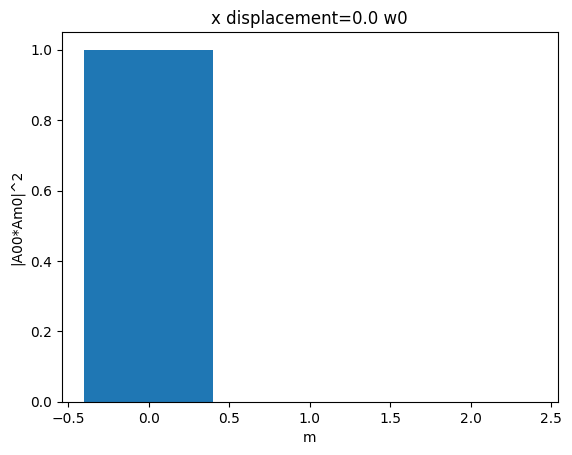

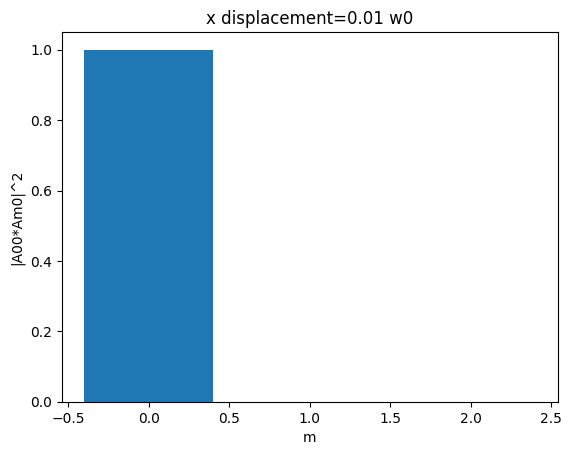

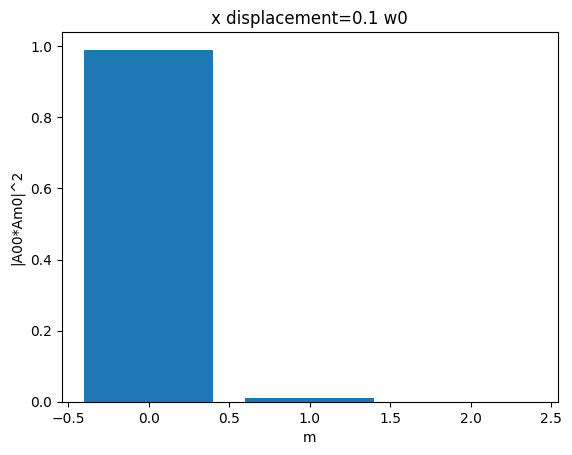

In [229]:
# find the overlap between the fundamental mode and the first couple of modes when there is a relative transverse displacement

dx_steps = [0,0.01*w0,0.1*w0]
m_max = 3
overlap_sqrd = np.zeros(m_max)

for dx in dx_steps:
    for m in range(m_max):
        Am0 = HGmn(w0,lmbda,m,0) # this should be the correct index to vary but i checked A0m just to be sure
        integrand = lambda x,y: conjugate(Am0(x,y,z))*A00(x-dx,y,z)
        overlap_sqrd[m] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
    plt.bar(range(m_max),overlap_sqrd)
    plt.title(f"x displacement={dx/w0}w0")
    plt.xlabel("m")
    plt.ylabel("|A00*Am0|^2")
    plt.show()

### Effect of different cavity misalignments

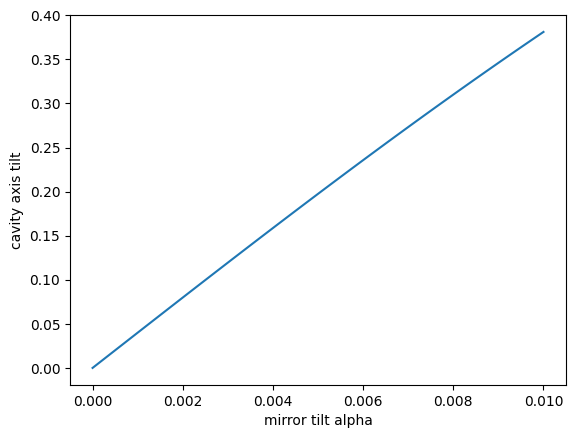

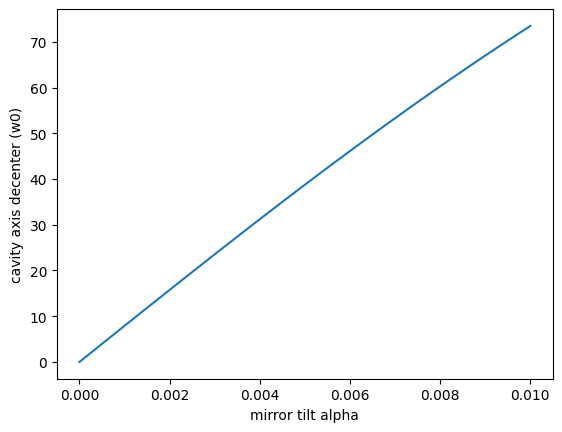

In [291]:
L = 3.95*mm # length
R = 2*mm # mirror radius of curvature of both mirrors
w0 = 0.01*mm

tilt = lambda alpha: arctan(R*sin(alpha)/(R+R*cos(alpha)-L))
decenter_x = lambda theta: (L/2)*sin(theta) # approximately. the amount the center of the mode is displaced in the tranverse direction
alpha_pts = linspace(0,0.01)
tilt_pts = tilt(alpha_pts)
plt.plot(alpha_pts,tilt_pts)
plt.xlabel("mirror tilt alpha")
plt.ylabel("cavity axis tilt")
plt.show()

plt.plot(alpha_pts,decenter_x(tilt_pts)/w0)
plt.xlabel("mirror tilt alpha")
plt.ylabel("cavity axis decenter (w0)")
plt.show()

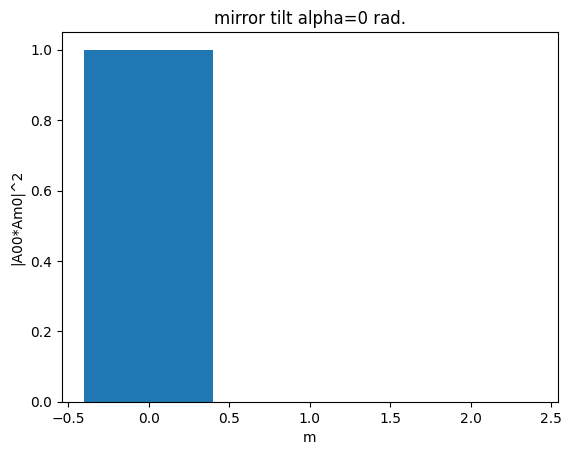

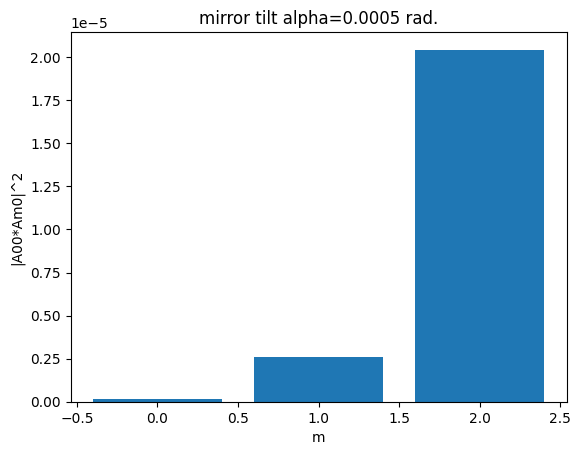

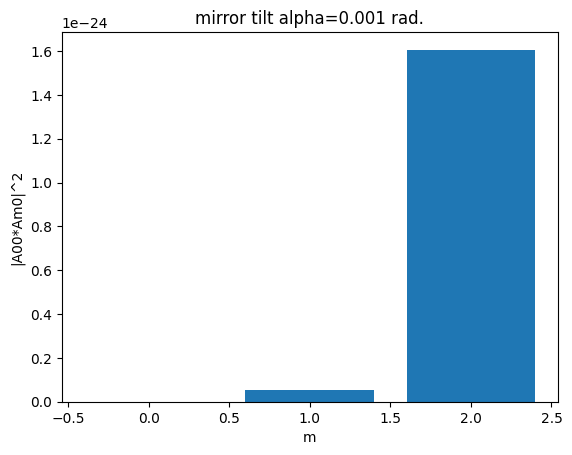

In [295]:
# find the overlap between the fundamental mode and the first couple of modes when
# there is a tilt of one mirror 

tilt = lambda alpha: arctan(R*sin(alpha)/(R+R*cos(alpha)-L))
decenter_x = lambda alpha: (L/2)*sin(theta) # approximately. the amount the center of the mode is displaced in the tranverse direction
# ignore decenter_z.

alpha_steps = [0,0.0005,0.001] # tilt about y axis going through the minimum of the mirror sag
m_max = 3
overlap_sqrd = np.zeros(m_max)

for alpha in alpha_steps:
    for m in range(m_max):
        Am0 = HGmn(w0,lmbda,m,0) # this should be the correct index to vary but i checked A0m just to be sure
        theta = tilt(alpha)
        dx = decenter_x(theta)
        integrand = lambda x,y: conjugate(Am0(x,y,z))*A00(x*cos(theta)+z*sin(theta)-dx,y,-x*sin(theta)+z*cos(theta))
        overlap_sqrd[m] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
    plt.bar(range(m_max),overlap_sqrd)
    plt.title(f"mirror tilt alpha={alpha} rad.")
    plt.xlabel("m")
    plt.ylabel("|A00*Am0|^2")
    plt.show()

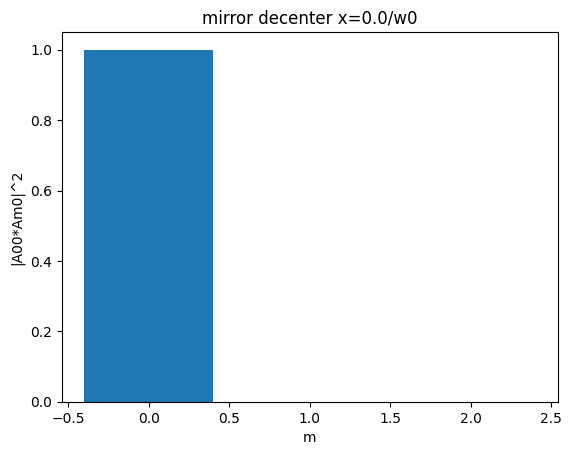

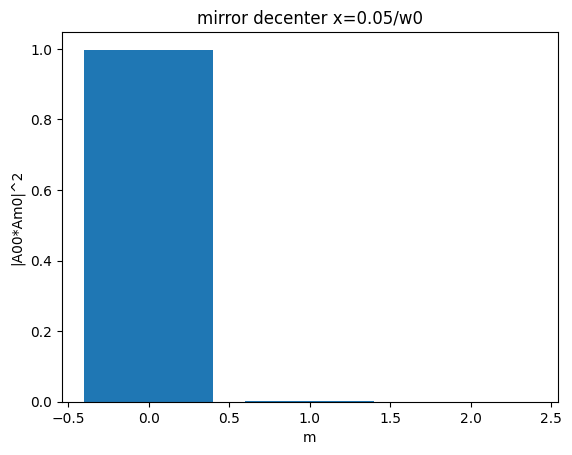

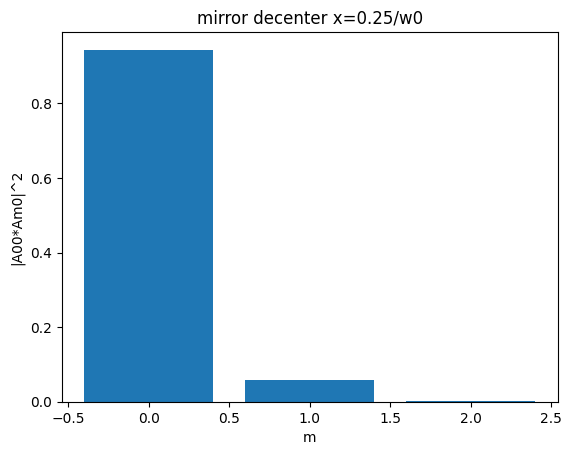

In [296]:
# find the overlap between the fundamental mode and the first couple of modes when
# there is a displacement of one mirror 

tilt = lambda dx: arctan(dx/(2*R-L))
decenter_x = lambda dx: dx/2 # approximately. the amount the center of the mode is displaced in the tranverse direction
# ignore decenter_z.

deltax_steps = [0,0.1*w0,0.5*w0] # tilt about y axis going through the minimum of the mirror sag
m_max = 3
overlap_sqrd = np.zeros(m_max)

for deltax in deltax_steps:
    for m in range(m_max):
        Am0 = HGmn(w0,lmbda,m,0) # this should be the correct index to vary but i checked A0m just to be sure
        theta = tilt(deltax)
        dx = decenter_x(deltax)
        integrand = lambda x,y: conjugate(Am0(x,y,z))*A00(x*cos(theta)+z*sin(theta)-dx,y,-x*sin(theta)+z*cos(theta))
        overlap_sqrd[m] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
    plt.bar(range(m_max),overlap_sqrd)
    plt.title(f"mirror decenter x={dx/w0}/w0")
    plt.xlabel("m")
    plt.ylabel("|A00*Am0|^2")
    plt.show()

## Cavity misalignment - more general tilt/decenters
When the output mirror is both decentered in x and tilted about an axis y which runs through the minimum of the sag. The input mirror is assumed fixed in the "aligned" coordinate frame, and an input Gaussian beam is assumed to be perfectly mode-matched so that if the output mirror is perfectly aligned, the input mode couples only to the fundamental transverse cavity mode. 

The expressions for tilt/decenters used here do not make approximations that were made above. However, there are still several approximations which are made:
 * We assume the tilted set of modes have the same waist parameter w0 as the untilted ones. This is not true in reality, since the length of the effective cavity also changes in general with mirror misalignment.
 * We ignore the finite size of the mirrors, which is to say there is no loss from clipping. This means that the overlap with the misaligned mode can be 1 for substantially tilted mirrors when the tilt effect is canceled by a suitable translation of the mirror, while in reality the mode might see significant loss.

In [248]:
# tilt and decenter of the cavity mode as a function of mirror tilt and decenter. I assume R1=R2=R.

R = 2*mm
L = 2*R - 50*um
lmbda = 780*nm
# near-conc. waist
w0 = sqrt(lmbda*L/(2*pi))*((R-L/2)/(L/2))**(1/4)

def tilt_and_decenter(alpha,dx):
    """the dx,dz, and theta of a cavity mode after tilting and decentering one of the mirrors"""
    theta = arctan((dx+R*sin(alpha))/(R+R*cos(alpha)-L))
    cc = sqrt((dx+R*sin(alpha))**2 + (R-L+R*cos(alpha))**2)
    decenter_x = cc/2*sin(theta)
    decenter_z = 0.5*(cc - (2*R-L)*cos(theta))
    return theta, decenter_x, decenter_z

In [285]:
n_xsteps = 11
n_alpha_steps = 2
deltax_steps = linspace(0,-1.5*w0,n_xsteps) # tilt about y axis going through the minimum of the mirror sag
alpha_steps = [0,0.005] #linspace(0,0.005,n_alpha_steps)

A10 = HGmn(w0,lmbda,1,0)

overlap = empty((n_alpha_steps,n_xsteps))
for i,alpha in enumerate(alpha_steps):
    for j,deltax in enumerate(deltax_steps):
        theta, dx, dz = tilt_and_decenter(alpha,deltax)
        integrand = lambda x,y: conjugate(A00(x,y,z))*A00((x-dx)*cos(theta)+(z-dz)*sin(theta),y,-(x-dx)*sin(theta)+(z-dz)*cos(theta))
        overlap[i,j] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2

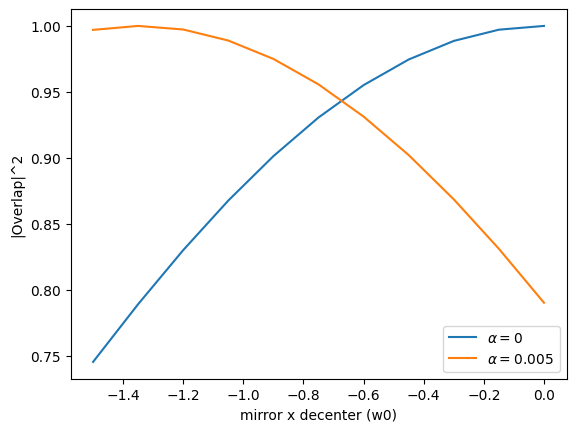

In [286]:
fig,ax=plt.subplots()
for i in range(n_alpha_steps):
    ax.plot(deltax_steps/w0,overlap[i,:],label=r'$\alpha=$'+str(round(alpha_steps[i],3)))
    ax.set_xlabel("mirror x decenter (w0)")
    ax.set_ylabel("|Overlap|^2")
ax.legend()
plt.show()

In [289]:
overlap

array([[1.        , 0.99714823, 0.98863139, 0.97456442, 0.95513745,
        0.93061352, 0.90132533, 0.86767074, 0.83010715, 0.78914443,
        0.74533653],
       [0.79019629, 0.83108104, 0.86855324, 0.90210434, 0.93127848,
        0.95567947, 0.97497641, 0.98890814, 0.99728644, 0.99999828,
        0.99700711]])

In [288]:
amax(overlap)

1.0

In [324]:
n_xsteps = 19
n_alpha_steps = 9
deltax_steps = linspace(-w0,w0,n_xsteps) # tilt about y axis going through the minimum of the mirror sag
alpha_steps = linspace(-0.02,0.02,n_alpha_steps)

A10 = HGmn(w0,lmbda,1,0)

overlap00_sqrd = np.zeros((n_alpha_steps,n_xsteps))
overlap10_sqrd = np.zeros((n_alpha_steps,n_xsteps))

print("calculating c00s...")
t0 = time()
for i,alpha in enumerate(alpha_steps):
    for j,deltax in enumerate(deltax_steps):
        theta, dx, dz = tilt_and_decenter(alpha,deltax)
        integrand = lambda x,y: conjugate(A00(x,y,z))*A00((x-dx)*cos(theta)+(z-dz)*sin(theta),y,-(x-dx)*sin(theta)+(z-dz)*cos(theta))
        overlap00_sqrd[i,j] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
print(f"finished in {(time()-t0)/60:.2f} minutes")
# print("calculating c10s...")
# t0 = time()
# for i,alpha in enumerate(alpha_steps):
#     for j,deltax in enumerate(deltax_steps):
#         theta, dx, dz = tilt_and_decenter(alpha,deltax)
#         integrand = lambda x,y: conjugate(A10(x,y,z))*A00(x*cos(theta)+z*sin(theta)-dx,y,-x*sin(theta)+z*cos(theta)-dz)
#         overlap10_sqrd[i,j] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2
# print(f"finished in {(time()-t0)/60:.2f} minutes")

calculating c00s...
finished in 43.44 minutes


In [349]:
# write to file
fname = './solns/overlap00_20230423.csv'
data = overlap00_sqrd
with open(fname, 'w',newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(list(deltax_steps)+[0.0])
    for i in range(n_alpha_steps):
        writer.writerow([alpha_steps[i]]+list(data[i]))
    f.close()

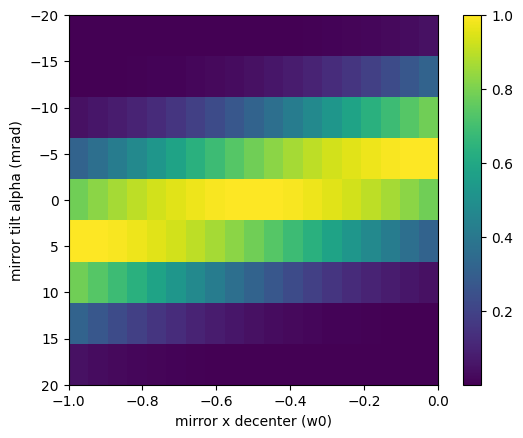

In [355]:
# read from file
fname = './solns/overlap00_20230423.csv'
data = []
mirror_alpha_steps = []
with open(fname) as f:
    reader = csv.reader(f)#,delimiter=',')
    mirror_dx_steps = [float(x) for x in reader.__next__()]
    for row in reader:
        mirror_alpha_steps.append(float(row[0]))
        data.append([float(x) for x in row[1:]])
    f.close()

fig,ax=plt.subplots()
cax = ax.imshow(data,extent=[mirror_dx_steps[0]/w0,mirror_dx_steps[-1]/w0,mirror_alpha_steps[-1]/mm,mirror_alpha_steps[0]/mm])
ax.set_aspect((mm/w0)*(mirror_dx_steps[0]-mirror_dx_steps[-1])/(mirror_alpha_steps[0]-mirror_alpha_steps[-1]))
ax.set_xlabel("mirror x decenter (w0)")
ax.set_ylabel("mirror tilt alpha (mrad)")
fig.colorbar(cax,norm=colors.Normalize(vmin=0.0, vmax=1.1))

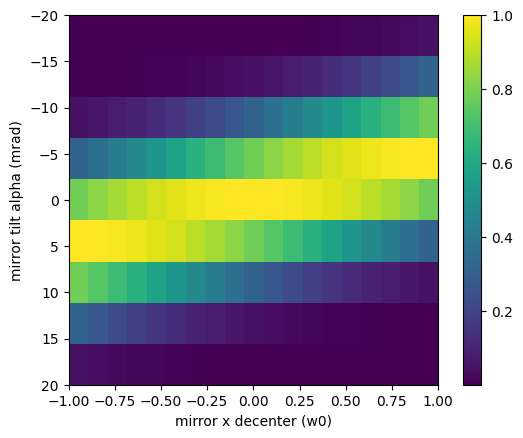

In [332]:
fig,ax=plt.subplots()
cax = ax.imshow(overlap00_sqrd,extent=[deltax_steps[0]/w0,deltax_steps[-1]/w0,alpha_steps[-1]/mm,alpha_steps[0]/mm])
ax.set_aspect((mm/w0)*(deltax_steps[0]-deltax_steps[-1])/(alpha_steps[0]-alpha_steps[-1]))
ax.set_xlabel("mirror x decenter (w0)")
ax.set_ylabel("mirror tilt alpha (mrad)")
fig.colorbar(cax,norm=colors.Normalize(vmin=0.0, vmax=1.1))

In [394]:
# build an interpolation function so we can approximate values of |c00|^2 at any point on a grid within the range of pts used for the calculation above
points = (alpha_steps,deltax_steps)
values = overlap00_sqrd
interp00 = RegularGridInterpolator(points, values, bounds_error=False, fill_value=None) # method='linear'

In [406]:
# check that the function gives 1 at alpha=deltax=0
interp00(array([0,0]))[0]

1.0

overlap interpolation evaluated at 1681 points in 0.0042s - way faster!


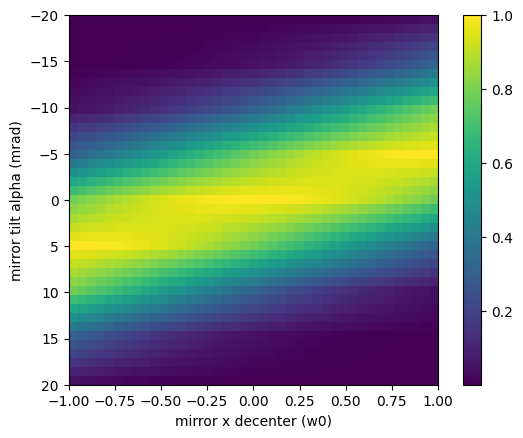

In [407]:
# plot an approximated higher resolution map of |c00|^2
n_points = 41
alpha_steps_hi_res = linspace(alpha_steps[0],alpha_steps[-1],n_points) # important - the interpolated function is only valid over the range of points we gave it
deltax_steps_hi_res = linspace(deltax_steps[0],deltax_steps[-1],n_points)

# evaluate the interpolation on a meshgrid so we get 2D data as before
t0 = time()
alpha_grid, deltax_grid = meshgrid(alpha_steps_hi_res,deltax_steps_hi_res, indexing='ij')
overlap00_hi_res = interp00((alpha_grid,deltax_grid))
print(f"overlap interpolation evaluated at {n_points**2} points in {time()-t0:.4f}s - way faster!")

fig,ax=plt.subplots()
cax = ax.imshow(overlap00_hi_res,extent=[deltax_steps[0]/w0,deltax_steps[-1]/w0,alpha_steps[-1]/mm,alpha_steps[0]/mm])
ax.set_aspect((mm/w0)*(deltax_steps[0]-deltax_steps[-1])/(alpha_steps[0]-alpha_steps[-1]))
ax.set_xlabel("mirror x decenter (w0)")
ax.set_ylabel("mirror tilt alpha (mrad)")
fig.colorbar(cax,norm=colors.Normalize(vmin=0.0, vmax=1.1))
plt.show()

In [ ]:
overlap

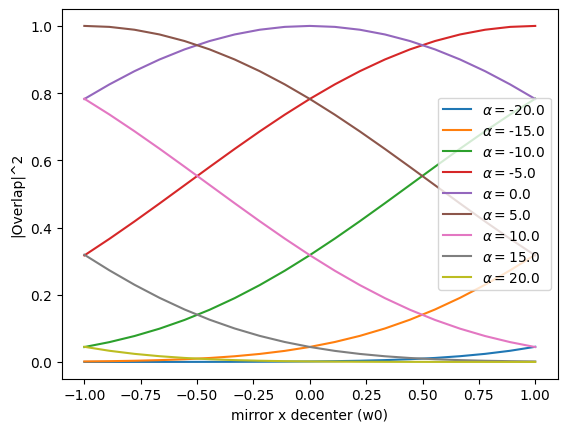

In [331]:
fig,ax=plt.subplots()
for i in range(n_alpha_steps):
    ax.plot(deltax_steps/w0,overlap00_sqrd[i,:],label=r'$\alpha=$'+str(round(alpha_steps[i]/mm,2)))
    ax.set_xlabel("mirror x decenter (w0)")
    ax.set_ylabel("|Overlap|^2")
ax.legend()
plt.show()
#     fig.colorbar(cax,norm=colors.Normalize(vmin=0.0, vmax=1.1))

In [326]:
# we can see that there is a line over which the overlap is 1, even when the mirror "misaligned". 

for i,alpha in enumerate(alpha_steps):
    for j,deltax in enumerate(deltax_steps):
        if overlap00_sqrd[i,j] > 0.999:
            print(f"Oij={overlap00_sqrd[i,j]}, alpha[j]={alpha}, dx[j]={deltax}")

Oij=0.9999999997552171, alpha[j]=-0.005000000000000001, dx[j]=1e-05
Oij=1.0, alpha[j]=0.0, dx[j]=0.0
Oij=0.9999999997552171, alpha[j]=0.005000000000000001, dx[j]=-1e-05


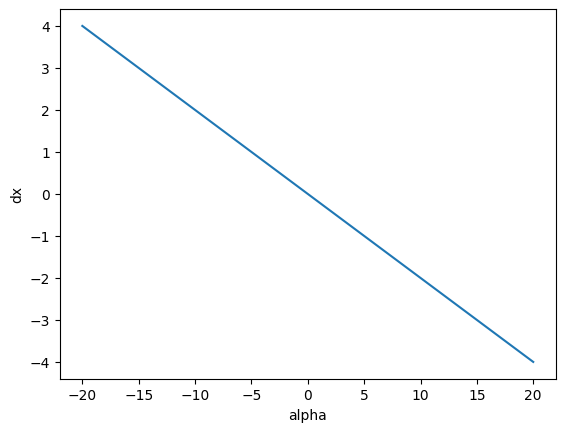

In [328]:
# the line where the overlap is ~ 1
dx_of_alpha = lambda dx : (-2e-5/0.01)*dx
plt.plot(alpha_steps/mm,dx_of_alpha(alpha_steps)/w0)
plt.xlabel("alpha (mrad)")
plt.ylabel("dx (w0)")
plt.show()

overlap00_sqrd_invar = empty(n_alpha_steps) 
for i,alpha in enumerate(alpha_steps):
    theta, dx, dz = tilt_and_decenter(alpha,dx_of_alpha(alpha))
    integrand = lambda x,y: conjugate(A00(x,y,z))*A00(x*cos(theta)+z*sin(theta)-dx,y,-x*sin(theta)+z*cos(theta)-dz)
    overlap00_sqrd_invar[i] = abs(dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0])**2

(0.99, 1.01)

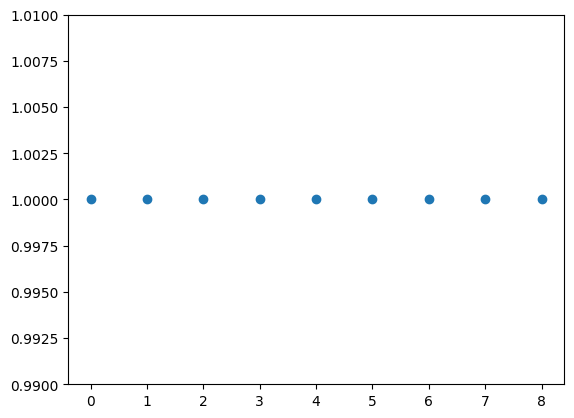

In [330]:
# verify that the overlap stays at 1 for the coordinates on the line defined above
fig, ax = plt.subplots()
ax.scatter(range(len(overlap00_sqrd_invar)),overlap00_sqrd_invar)
ax.set_ylim((0.99,1.01))
# ticks = range(len(overlap00_sqrd_invar))
# labels = [$''$]
# ax.set_xticks(ticks)
# ax.set_xticklabels(xlabels, rotation=70, ha=ha[n])


In [ ]:
## todo add in clipping from finite mirror size

## Cavity resonances

In [160]:
# cavity parameters
L = 3.95*mm # length
R1 = R2 = 2*mm # mirror radius of curvature
lmbda = 780*nm

# stability parameters
g1 = 1 - L/R1
g2 = 1 - L/R2

# free spectral range
nuFSR = c/(2*L)

# resonance frequency of the cavity mode m,n, longitudinal index q 
nu_mnq = lambda m,n,q: nuFSR*(q+(1 + m + n)*arccos(sign(g1)*sqrt(g1*g2))/pi)

In [162]:
# plot of the cavity spectrum
F = 1000 # finesse
nuFWHM = nuFSR/F # the cavity FWHM linewidth 

print((nu_mnq(0,0,1) - nu_mnq(0,0,0))/nuFSR)
print((nu_mnq(1,0,0) - nu_mnq(0,0,0))/nuFSR)

1.0
0.9286746214389777


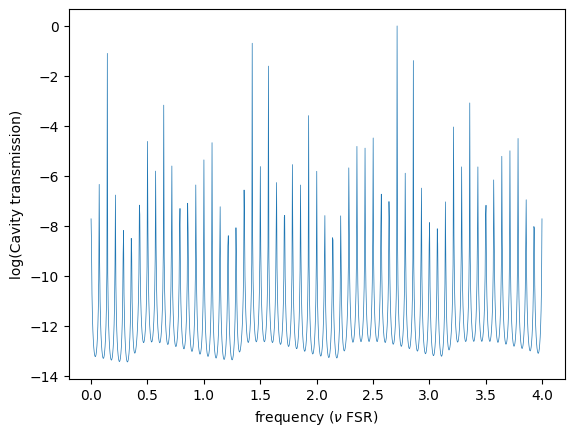

In [184]:
# plot the cavity resonances
# large spikes are where there are large degeneracies

pts = 1000
trace_pts = zeros(pts) # the cavity transmission
nu_pts = linspace(0,4*nuFSR,pts) # frequency steps

for q in range(-20,20):
    for m in range(20):
        for n in range(20):
            mode = lambda nu: 1/(1+(nu-nu_mnq(m,n,q))**2)
            trace_pts += mode(nu_pts)
            
fig,ax = plt.subplots()
ax.plot(nu_pts/nuFSR,log(trace_pts/max(trace_pts)),lw='0.5')
ax.set_xlabel(r'frequency ($\nu$ FSR)')
ax.set_ylabel('log(Cavity transmission)')
plt.show()

## Orthogonality tests

In [139]:
## verify that the HG beams are orthonormal

mm = 10**-3
w0 = 0.1*mm
lmbda = 7.8*10**-4*mm
z = 10**-9*mm

# limits for the numerical integration. x >> w0 is basically infinity
xmax = ymax = 20*w0
xmin = ymin = -xmax

# overlap of any mode with itself should be 1
A00 = HGmn(w0,lmbda,0,0)
integrand = lambda x,y: abs(A00(x,y,z))**2

overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)
assert round(real(overlap[0]),6) == 1 and round(imag(overlap[0]),6) == 0, print(overlap) # assert the overlap is real and basically = 1

A11 = HGmn(w0,lmbda,1,1)
integrand = lambda x,y: abs(A11(x,y,z))**2

overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)
assert round(real(overlap[0]),6) == 1 and round(imag(overlap[0]),6) == 0, print(overlap)

# overlap of any mode with any different mode should be 0
A01 = HGmn(w0,lmbda,0,1)
integrand = lambda x,y: conjugate(A00(x,y,z))*A01(x,y,z)

overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)
assert overlap[0] == 0, print(overlap)

A22 = HGmn(w0,lmbda,2,2)
integrand = lambda x,y: conjugate(A11(x,y,z))*A22(x,y,z)

overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)
assert overlap[0] == 0, print(overlap)

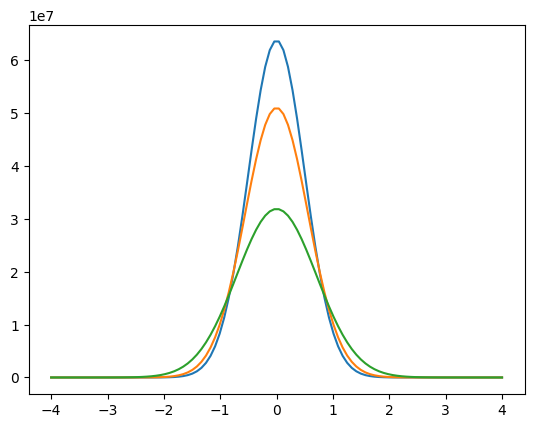

In [93]:
zR = pi*w0**2/lmbda
zpts = [10**-8, 0.5*zR, zR]
I00 = lambda x,y,z: conjugate(A00(x,y,z))*A00(x,y,z)
for z in zpts:
    xpts = linspace(-4*w0,4*w0,100)
    plt.plot(xpts/w0,real(I00(xpts,0,z)))
#     plt.plot(xpts/w0,imag(I00(xpts,0,z)))

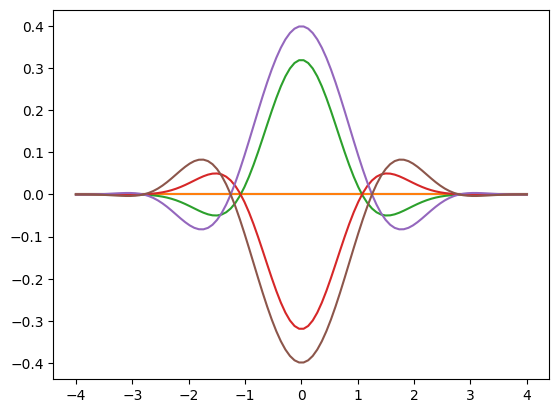

In [104]:
zR = pi*w0**2/lmbda
zpts = [10**-8, 0.5*zR, zR]
for z in zpts:
    xpts = linspace(-4*w0,4*w0,100)
    plt.plot(xpts/w0,imag(conjugate(A00(xpts,0,z))))
    plt.plot(xpts/w0,imag(A00(xpts,0,z)))

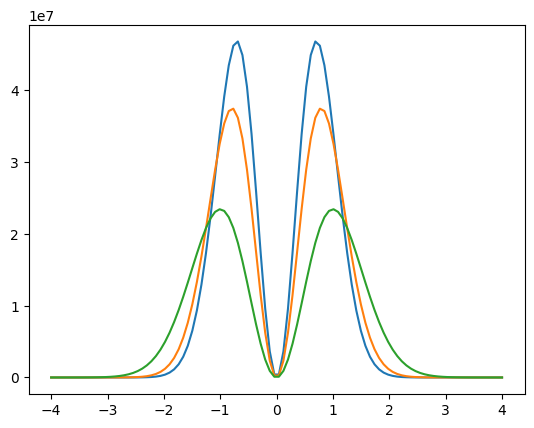

In [94]:
zR = pi*w0**2/lmbda
zpts = [10**-8, 0.5*zR, zR]
I01 = lambda x,y,z: conjugate(A01(x,y,z))*A01(x,y,z)
for z in zpts:
    xpts = linspace(-4*w0,4*w0,100)
    plt.plot(xpts/w0,real(I01(xpts,0,z)))
#     plt.plot(xpts/w0,imag(I01(xpts,0,z)))

## Integration tests

In [113]:
def quad_complex(func, a, b, **kwargs):
    """
    Compute a single integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    """
    def real_func(x):
        return real(func(x))
    def imag_func(x):
        return imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

def dblquad_complex(func, ax, bx, ay, by, **kwargs):
    """
    Compute a double integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    
    returns a 3-tuple (result, real error, imaginary part error)
    """
    def real_func(x,y):
        return real(func(x,y))
    def imag_func(x,y):
        return imag(func(x,y))
    real_integral = dblquad(real_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    imag_integral = dblquad(imag_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

In [114]:
quad_complex(lambda x: (exp(1j*x)), a=0, b=pi/2)

((0.9999999999999999+0.9999999999999999j),
 (1.1102230246251564e-14,),
 (1.1102230246251564e-14,))

In [115]:
dblquad_complex(lambda x,y: (exp(1j*sqrt(x**2+y**2))), ax=-10, bx=10, ay=-10, by=10)

((-38.44378720197425-3.8434453352689872j),
 (8.617970226332261e-11,),
 (5.481955719108238e-08,))

In [116]:
A00 = lambda x,y: exp(-(x**2+y**2))
integrand = lambda x,y: A00(x,y)**2
dblquad_complex(integrand, ax=-inf, bx=inf, ay=-inf, by=inf)

((1.5707963267954526+0j), (1.4206754779531565e-08,), (0,))

In [111]:
dblquad?